In [16]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Loss
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

In [17]:
# Read Data
train = pd.read_csv("C:/Users/rihot/Desktop/Deep_learning/capston_assignment/Preprocessed_data/datafile_nan.csv")

# Index column drop
# Index 열은 Quality에 영향을 주지 않음
train = train.drop(['xq'], axis=1)

# 데이터 타입에 따라 분류
numerical_columns = train.select_dtypes(exclude='object').columns.tolist()

# 확인을 위한 호출
print(numerical_columns)

['Kp_inter', 'Ap_inter', 'F107_inter', 'SunSpot_inter', 'dst', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'C_D', 'S_D', 'C_H', 'S_H', 'tec_ex(T1)']
['Kp_inter', 'Ap_inter', 'F107_inter', 'SunSpot_inter', 'dst', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'C_D', 'S_D', 'C_H', 'S_H', 'tec_ex(T1)']


In [18]:
Y = train['tec_ex(T1)'].values
X = []

for i, rows in train.iterrows():
    # 데이터 프레임을 가로 한줄씩 출력 row
    X.append([ rows['Kp_inter'], rows['Ap_inter'], rows['F107_inter'], rows['SunSpot_inter'], rows['dst']
                , rows['T1'], rows['T2'], rows['T3'], rows['T4'], rows['T5'], rows['T6'], rows['T7'], rows['T8'], rows['T9']
                , rows['T10'], rows['T11'], rows['T12'], rows['T13'], rows['T14'], rows['T15'], rows['T16']
                , rows['C_D'], rows['S_D'], rows['C_H'], rows['S_H']])

In [19]:
Y = Y.reshape((-1,1)) # reshape(-1,1) 열 값은 지정했으니 알아서 행 지정해서 배열로 만들기

# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scalerX = MinMaxScaler()
scalerX.fit(X)
X = scalerX.transform(X)

scalerY = MinMaxScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

In [20]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [21]:
# Hyper parameter tuning

CFG = {
    'EPOCHS':500, #에포크
    'LEARNING_RATE':3e-4, #학습률
    'BATCH_SIZE':16, #배치사이즈
    'SEED':41, #시드
}

In [22]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
X_train, X_T, Y_train, Y_T = train_test_split(X, Y, test_size=0.4)
X_val, X_test, Y_val, Y_test = train_test_split(X_T, Y_T, test_size=0.5)
# train : val : test = 0.6 : 0.2 : 0.2

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=CFG['BATCH_SIZE'], shuffle=True)

valsets = TensorData(X_val, Y_val)
valloader = torch.utils.data.DataLoader(valsets, batch_size=CFG['BATCH_SIZE'], shuffle=False)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [23]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(25, 64, bias=False),
            nn.BatchNorm1d(64, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(64, 128, bias=False),
            nn.BatchNorm1d(128, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(128, 256, bias=False),
            nn.BatchNorm1d(256, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )
        
        self.layer4 = nn.Linear(256, 1, bias=False)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
      
        return x

In [24]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'], weight_decay=1e-7)

In [25]:
loss_ = [] # loss 저장할 리스트
val_loss_ = [] # val loss 저장할 리스트

def train(model, optimizer, trainloader):
    n = len(trainloader)
    
    # Loss Function
    criterion = nn.MSELoss()
    best_acc = 0
    
    for epoch in range(1, CFG["EPOCHS"]+1):
        model.train()
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            inputs, values = data
            
            optimizer.zero_grad() # 최적화 초기화
            
            outputs = model(inputs) # 예측값 산출
            loss = criterion(outputs, values) # Error 계산
            
            loss.backward() # 역전파 진행
            optimizer.step() # 역전파 진행 후 가중치 업데이트
            
            running_loss += loss.item() # Epoch 마다 평균 loss를 계산하기 위한 배치 loss
                                        # item() 텐서로 값 받아오기
        
        loss_.append(running_loss/n) # MSE 계산
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(trainloader)))
        
        #validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        val_loss = 0.0
        
        predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
        actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.
        
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for i, data in enumerate(valloader, 0):
                inputs, values = data

                outputs = model(inputs)
                val_loss += criterion(outputs, values)
                
                predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
                actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

                val_loss_.append(val_loss / n)

                if i == len(valloader):
                    torch.save(model.state_dict(), "C:/Users/rihot/Desktop/Deep_learning/capston_assignment/last_model.pth")
        
        predictions = predictions.numpy() # 넘파이 배열로 변경.
        actual = actual.numpy() # 넘파이 배열로 변경.
        rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.
        print(f'val rmse:{rmse}')
        
        

In [26]:
train(model, optimizer, trainloader)

[1] Train loss: 0.0280752903
test rmse:0.0978846624493599
[2] Train loss: 0.0143849628
test rmse:0.0825275406241417
[3] Train loss: 0.0110570675
test rmse:0.07629279047250748
[4] Train loss: 0.0094572878
test rmse:0.06935951113700867
[5] Train loss: 0.0085661333
test rmse:0.07322986423969269
[6] Train loss: 0.0081437482
test rmse:0.07057426124811172
[7] Train loss: 0.0072937420
test rmse:0.0683363825082779
[8] Train loss: 0.0069935788
test rmse:0.060495320707559586
[9] Train loss: 0.0068117572
test rmse:0.060628145933151245
[10] Train loss: 0.0063076014
test rmse:0.05600212514400482
[11] Train loss: 0.0064882651
test rmse:0.058224789798259735
[12] Train loss: 0.0059762407
test rmse:0.06257019191980362
[13] Train loss: 0.0053733510
test rmse:0.05324079468846321
[14] Train loss: 0.0050452305
test rmse:0.05360894650220871
[15] Train loss: 0.0051672611
test rmse:0.05233246088027954
[16] Train loss: 0.0049786655
test rmse:0.06268136948347092
[17] Train loss: 0.0045699479
test rmse:0.0610579

KeyboardInterrupt: 

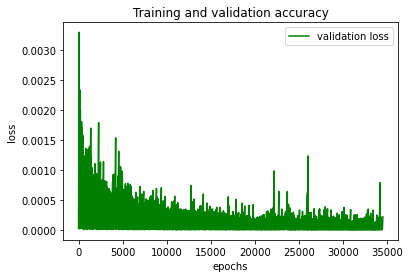

In [ ]:
plt.clf()
# plt.plot(loss_,'ro',label='training loss')
plt.plot(val_loss_,'g',label='validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# test set 평가

def predict(model, testloader):
    model.eval()  #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
    model_pred = []
    test_loss = 0.0

    with torch.no_grad():  #파라미터 업데이트 안하기 때문에 no_grad 사용
        for i, data in enumerate(testloader, 0):
            inputs, values = data
            outputs = model(inputs)
            test_loss += criterion(outputs, values)

            model_pred.extend(outputs.tolist())
        print(f'test loss:{test_loss}')
    return model_pred

In [ ]:
# load last model

checkpoint = torch.load("C:/Users/rihot/Desktop/Deep_learning/capston_assignment/last_model.pth")
model = Regressor()
model.load_state_dict(checkpoint)

preds = predict(model, testloader)

preds = scalerY.inverse_transform(preds)
Y_test = scalerY.inverse_transform(Y_test)

# check your prediction
preds[0:5], Y_test[0:5]

tensor(0.1004)


(array([[ 7.99589808],
        [21.48107106],
        [16.37450781],
        [ 5.86763775],
        [19.24636546]]),
 array([[ 4. ],
        [22. ],
        [16. ],
        [ 4. ],
        [18.8]]))

In [ ]:
submission = pd.read_csv("C:/Users/rihot/Desktop/Deep_learning/capston_assignment/sample_submission.csv")
submission['tec_ex(T1)'] = preds

submission.to_csv("C:/Users/rihot/Desktop/Deep_learning/capston_assignment/submit.csv", index=False)